In [5]:
#IMPORTANT IMPORT
from pynq import Overlay
import numpy as np
import time
import math
import matplotlib.pyplot as plt

In [126]:
## Overlay for pipeline FFT only for N = 8
fft_ov = Overlay("design_1_wrapperV2.xsa")
fft_pipeN8 = fft_ov.fft_pipe_N8_0.mmio

In [127]:
# Sample generator
N = 8
FXP = 1024
data_real = np.array([])
data_imag = np.array([])
data_complex = np.array([])

for i in range (N):
    data_real = np.append(data_real,np.random.rand())
    data_imag = np.append(data_imag,np.random.rand())

    
data_complex = data_real + 1j*data_imag

#Convert data to data fixed-point 14:10
for i in range (N):
    data_real[i] =  int(data_real[i]*FXP)
    data_imag[i] =  int(data_imag[i]*FXP)


In [128]:
#Sample function

def fft_sample(x):
    N = len(x)
    if N == 1:
        return [x[0]]
    X = [0] * N
    even = fft_sample(x[:N:2])
    odd = fft_sample(x[1:N:2])
    for k in range(N // 2):
        w = math.e ** (-2j * math.pi * k / N)
        X[k] = even[k] + w * odd[k]
        X[k + N // 2] = even[k] - w * odd[k]
    return X

In [129]:
# FFT Implementation on FPGA (Pipeline only for FFT N = 8)
N_size = 8
start_offset = 0
ready_offset = 132
in_buffer_offset = [x*4 for x in range(1,17)]
out_buffer_offset = [x*4 for x in range(17,33)]

def convert_for_signed_24bit(number):
    if number >= 0x800000:
        return number - 0x1000000
    else:
        return number

def fft_pipelineN8(in_r, in_i):
    out_r = np.array([])
    out_i = np.array([])
    fft_pipeN8.write(start_offset,0)
    for i in range(N_size):
        fft_pipeN8.write(in_buffer_offset[i],int(in_r[i]))
        fft_pipeN8.write(in_buffer_offset[i+N_size],int(in_i[i]))
    start2_ = time.time()
    fft_pipeN8.write(start_offset,1)    
    while (fft_pipeN8.read(ready_offset) == 0):
        pass 
    stop2_ = time.time()
    for i in range(N_size):
        out_r = np.append(out_r, fft_pipeN8.read(out_buffer_offset[i]))
        out_i = np.append(out_i, fft_pipeN8.read(out_buffer_offset[i+N_size]))
    for i in range(N_size):
        out_r[i] = convert_for_signed_24bit(out_r[i])
        out_i[i] = convert_for_signed_24bit(out_i[i])
    #fft_pipeN8.write(start_offset,0)
    return (out_r, out_i, stop2_-start2_)
    

Sample function -  Time =  0.0007157326
Pipeline FFT N=8 - Time =  0.0015652180 (with data pushing and reading) 
Pipeline FFT N=8 - Time =  0.0000243187 (time only between START-READY state)
RMSE: 0.002072458628029


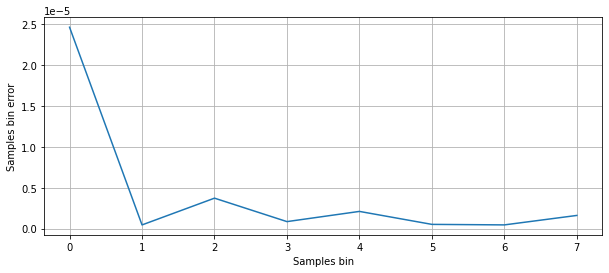

In [131]:
#Implementation comparison -> Sample function vs FFT Implementation on FPGA (Pipeline only for FFT N = 8)

#Compute FFT using sample function
start1 = time.time()
X_sample = fft_sample(data_complex)
stop1 = time.time()

#Compute FFT using FFT Implementation on FPGA (Pipeline only for FFT N = 8)
start2 = time.time()
X_fpga_r_pipeN8 , X_fpga_i_pipeN8, calc_time = fft_pipelineN8(data_real, data_imag)
stop2 = time.time()


X_fpga_complex_pipeN8 = np.array([])
X_fpga_complex_pipeN8 = X_fpga_r_pipeN8 + 1j*X_fpga_i_pipeN8
X_fpga_complex_pipeN8 = X_fpga_complex_pipeN8/1024

# Error between sample implementation and fpga implementation
X_err_pipeN8 = np.abs(X_fpga_complex_pipeN8 - X_sample)**2
# RMSE
X_RMSE_pipeN8 = np.sqrt(np.mean(X_err_pipeN8))
print('Sample function -  Time = ',"%.10f" % (stop1-start1))
print('Pipeline FFT N=8 - Time = ',"%.10f" % (stop2-start2),'(with data pushing and reading) ')
print('Pipeline FFT N=8 - Time = ',"%.10f" % calc_time, '(time only between START-READY state)')
print('RMSE:', np.round(X_RMSE_pipeN8, 15))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
ax.plot(X_err_pipeN8)
ax.set_ylabel('Samples bin error')
ax.set_xlabel('Samples bin')
plt.grid()
plt.show()

In [132]:
## Overlay for FFT with parallel butterflies
fft_ov = Overlay("fft_parallel_wrapper.xsa")
fft_parallel = fft_ov.fft_parallel_ip_0.mmio

In [133]:
# FFT Implementation on FPGA (Parallel butterflies)

N_size = 8
start_offset = 8
data_en_offset = 12
ready_offset = 16
in_R_offset = 20
in_I_offset = 24
out_R_offset = 28
out_I_offset = 32


def convert_for_signed_24bit(number):
    if number >= 0x800000:
        return number - 0x1000000
    else:
        return number

def fft_parall(in_r, in_i):
    out_r = np.array([])
    out_i = np.array([])
    
    fft_parallel.write(in_R_offset,int(in_r[0]))
    fft_parallel.write(in_I_offset,int(in_i[0]))
    
    fft_parallel.write(start_offset,1)    
    
    for i in range(1, N_size):
        fft_parallel.write(data_en_offset,1)
        fft_parallel.write(in_R_offset,int(in_r[i]))
        fft_parallel.write(in_I_offset,int(in_i[i]))
        fft_parallel.write(data_en_offset,0)
    
    start4_ = time.time()    
    while (fft_parallel.read(ready_offset) == 0):
        pass
        fft_parallel.write(data_en_offset,1)
        fft_parallel.write(data_en_offset,0)
    stop4_ = time.time()
        
    for i in range(N_size):
        fft_parallel.write(data_en_offset,1)
        out_r = np.append(out_r, fft_parallel.read(out_R_offset))
        out_i = np.append(out_i, fft_parallel.read(out_I_offset))
        fft_parallel.write(data_en_offset,0)
    for i in range(N_size):
        out_r[i] = convert_for_signed_24bit(out_r[i])
        out_i[i] = convert_for_signed_24bit(out_i[i])
    fft_parallel.write(start_offset,0)
    return (out_r, out_i,stop4_-start4_)

Sample function -  Time =  0.0005798340
Parallel FFT    -  Time =  0.0018868446 (with data pushing and reading) 
Parallel FFT    -  Time =  0.0000433922 (time only between START-READY state)
RMSE: 0.002072458628029


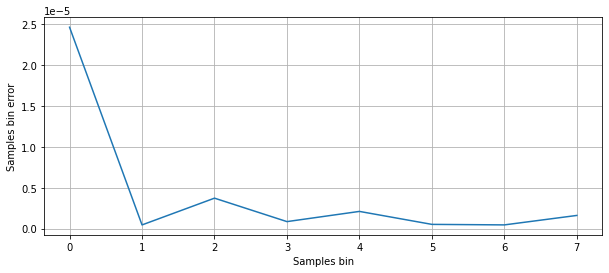

In [135]:
#Implementation comparison -> Sample function vs FFT Implementation on FPGA (Parallel Butterflies)

#Compute FFT using sample function
start3 = time.time()
X_sample = fft_sample(data_complex)
stop3 = time.time()

#Compute FFT using FFT Implementation on FPGA (Parallel Butterflies)
start4 = time.time()
X_fpga_r_parallel , X_fpga_i_parallel, calc_time_parallel = fft_parall(data_real, data_imag)
stop4 = time.time()

X_fpga_complex_parallel = np.array([])
X_fpga_complex_parallel = X_fpga_r_parallel + 1j*X_fpga_i_parallel
X_fpga_complex_parallel = X_fpga_complex_parallel/1024

# Error between sample implementation and fpga implementation
X_err_parallel = np.abs(X_fpga_complex_parallel - X_sample)**2
# RMSE
X_RMSE_parallel = np.sqrt(np.mean(X_err_parallel))
print('Sample function -  Time = ',"%.10f" % (stop3-start3))
print('Parallel FFT    -  Time = ',"%.10f" % (stop4-start4),'(with data pushing and reading) ')
print('Parallel FFT    -  Time = ',"%.10f" % calc_time_parallel, '(time only between START-READY state)')
print('RMSE:', np.round(X_RMSE_parallel, 15))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
ax.plot(X_err_parallel)
ax.set_ylabel('Samples bin error')
ax.set_xlabel('Samples bin')
plt.grid()
plt.show()

In [136]:
## Overlay for FFT with parallel butterflies
fft_ov = Overlay("fft_seq_wrapper.xsa")
fft_seq = fft_ov.fft_seq_ip_0.mmio

In [137]:
# FFT Implementation on FPGA (Parallel butterflies)

N_size = 8
start_offset = 8
data_en_offset = 12
ready_offset = 16
in_R_offset = 20
in_I_offset = 24
out_R_offset = 28
out_I_offset = 32


def convert_for_signed_24bit(number):
    if number >= 0x800000:
        return number - 0x1000000
    else:
        return number

def fft_sequential(in_r, in_i):
    out_r = np.array([])
    out_i = np.array([])
    
    fft_seq.write(in_R_offset,int(in_r[0]))
    fft_seq.write(in_I_offset,int(in_i[0]))
    
    fft_seq.write(start_offset,1)    
    
    for i in range(1,N_size):
        fft_seq.write(data_en_offset,1)
        fft_seq.write(in_R_offset,int(in_r[i]))
        fft_seq.write(in_I_offset,int(in_i[i]))
        fft_seq.write(data_en_offset,0)
    
    start6_ = time.time()    
    while (fft_seq.read(ready_offset) == 0):
        pass
        fft_seq.write(data_en_offset,1)
        fft_seq.write(data_en_offset,0)
    
    stop6_ = time.time()
        
    for i in range(N_size):
        fft_seq.write(data_en_offset,1)
        out_r = np.append(out_r, fft_seq.read(out_R_offset))
        out_i = np.append(out_i, fft_seq.read(out_I_offset))
        fft_seq.write(data_en_offset,0)
    for i in range(N_size):
        out_r[i] = convert_for_signed_24bit(out_r[i])
        out_i[i] = convert_for_signed_24bit(out_i[i])
    fft_seq.write(start_offset,0)
    return (out_r, out_i,stop6_-start6_)

Sample function -  Time =  0.0005526543
Sequential FFT  -  Time =  0.0019176006 (with data pushing and reading) 
Sequential FFT  -  Time =  0.0000419617 (time only between START-READY state)
RMSE: 0.002072458628029


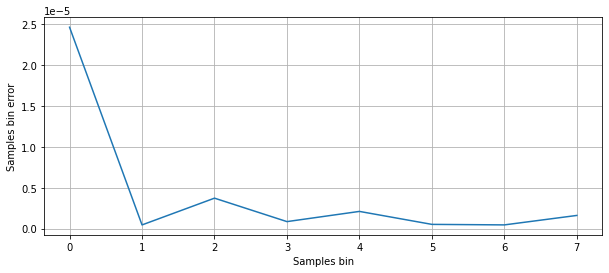

In [138]:
#Implementation comparison -> Sample function vs FFT Implementation on FPGA (Parallel Butterflies)

#Compute FFT using sample function
start5 = time.time()
X_sample = fft_sample(data_complex)
stop5 = time.time()

#Compute FFT using FFT Implementation on FPGA (Parallel Butterflies)
start6 = time.time()
X_fpga_r_seq , X_fpga_i_seq, calc_time_seq = fft_sequential(data_real, data_imag)
stop6 = time.time()

X_fpga_complex_seq = np.array([])
X_fpga_complex_seq = X_fpga_r_seq + 1j*X_fpga_i_seq
X_fpga_complex_seq = X_fpga_complex_seq/1024

# Error between sample implementation and fpga implementation
X_err_seq = np.abs(X_fpga_complex_seq - X_sample)**2
# RMSE
X_RMSE_seq = np.sqrt(np.mean(X_err_seq))
print('Sample function -  Time = ',"%.10f" % (stop5-start5))
print('Sequential FFT  -  Time = ',"%.10f" % (stop6-start6),'(with data pushing and reading) ')
print('Sequential FFT  -  Time = ',"%.10f" % calc_time_seq, '(time only between START-READY state)')
print('RMSE:', np.round(X_RMSE_seq, 15))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
ax.plot(X_err_seq)
ax.set_ylabel('Samples bin error')
ax.set_xlabel('Samples bin')
plt.grid()
plt.show()

In [139]:
#Implementation comparison

print('Sample function -  Time = ',"%.10f" % (stop3-start3))
print('Pipeline FFT N=8 - Time = ',"%.10f" % (stop2-start2),'(with data pushing and reading) ')
print('Pipeline FFT N=8 - Time = ',"%.10f" % calc_time, '(time only between START-READY state)')
print('')
print('Parallel FFT    -  Time = ',"%.10f" % (stop4-start4),'(with data pushing and reading) ')
print('Parallel FFT    -  Time = ',"%.10f" % calc_time_parallel, '(time only between START-READY state)')
print('')
print('Sequential FFT  -  Time = ',"%.10f" % (stop6-start6),'(with data pushing and reading) ')
print('Sequential FFT  -  Time = ',"%.10f" % calc_time_seq, '(time only between START-READY state)')
print('')
print('RMSE pipeline FFT:', np.round(X_RMSE_pipeN8, 15))
print('RMSE parallel FFT:', np.round(X_RMSE_parallel, 15))
print('RMSE sequential FFT:', np.round(X_RMSE_seq, 15))

Sample function -  Time =  0.0005798340
Pipeline FFT N=8 - Time =  0.0015652180 (with data pushing and reading) 
Pipeline FFT N=8 - Time =  0.0000243187 (time only between START-READY state)

Parallel FFT    -  Time =  0.0018868446 (with data pushing and reading) 
Parallel FFT    -  Time =  0.0000433922 (time only between START-READY state)

Sequential FFT  -  Time =  0.0019176006 (with data pushing and reading) 
Sequential FFT  -  Time =  0.0000419617 (time only between START-READY state)

RMSE pipeline FFT: 0.002072458628029
RMSE parallel FFT: 0.002072458628029
RMSE sequential FFT: 0.002072458628029
